<a href="https://colab.research.google.com/github/TonyStone23/UAV-for-Concrete-Crack-Inspection/blob/main/Bridge_Crack_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete Crack Detection
* CSC-499, SCSU
* Tony Stone
* Dataset: Concrete Crack Detection Dataset from Mendeley Data
* Model: CNN (EfficientNet + B0) from tensorflow

* Resources:
  * TensorFlow Documentation: https://www.tensorflow.org/tutorials/images/classification#create_a_dataset
  * Mendeley Dataset: https://data.mendeley.com/datasets/5y9wdsg2zt/2
  * GitHub Example 1: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/16_cnn_cifar10_small_image_classification/cnn_cifar10_dataset.ipynb

  * GitHub Example 2: https://github.com/norahb/Image_classificaiton_EfficientNet/blob/main/Binary_Image_Classification_EfficientNet.ipynb
* Additional Notes
  * Initiate runtime with GPU

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import shutil
import random as r

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras import models
from google.colab import drive
drive.mount('/content/drive')

r.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data_set = "Mendeley Data"
data_set = "Bridge Cracks"

In [ ]:
# Collect images from origional Mendeley Dataset, and create a Subset
source_directory = f"/content/drive/MyDrive/{data_set}"
destination_directory = "/content/Subset"

classes = ["Negative", "Positive"]

# number of images per class to keep
n_samples = 1000

# Clear destination if it already exists
if os.path.exists(destination_directory):
    shutil.rmtree(destination_directory)
os.makedirs(destination_directory)

for cls in classes:
    src_class_dir = os.path.join(source_directory, cls)
    dst_class_dir = os.path.join(destination_directory, cls)
    images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    r.shuffle(images)

    os.makedirs(dst_class_dir, exist_ok=True)

    # Limit to n_samples if class has more images
    images = images[:n_samples]

    # Copy files
    for img in images:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print("Subset created at:", destination_directory)

Subset created at: /content/Subset


In [ ]:
data_dir = destination_directory

batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
['Negative', 'Positive']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Load a Pre-Trained Model
baseModel = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False)
baseModel.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = baseModel(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = models.Model(inputs, outputs)

In [ ]:
"""
# Model from Scratch
num_classes = len(class_names)
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dense(10, activation = 'relu'),
  layers.Flatten(),
  layers.Dense(1, activation = 'sigmoid'),
])
"""

In [ ]:
# Compile Model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy, metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall"),
                  ])

In [ ]:
model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Train Model
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7237 - loss: 0.5774 - precision: 0.7762 - recall: 0.5605 - val_accuracy: 0.9175 - val_loss: 0.3783 - val_precision: 0.9343 - val_recall: 0.9128
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9093 - loss: 0.3661 - precision: 0.9247 - recall: 0.8837 - val_accuracy: 0.9250 - val_loss: 0.2773 - val_precision: 0.9608 - val_recall: 0.8991
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9224 - loss: 0.2799 - precision: 0.9197 - recall: 0.9232 - val_accuracy: 0.9325 - val_loss: 0.2310 - val_precision: 0.9659 - val_recall: 0.9083
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9299 - loss: 0.2465 - precision: 0.9429 - recall: 0.9098 - val_accuracy: 0.9450 - val_loss: 0.1990 - val_precision: 0.9623 - val_recall: 0.9358
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9410 - loss: 0.2075 - precision: 0.9445 - recall: 0.9343 - val_accuracy: 0.9525 - val_loss: 0.1800 

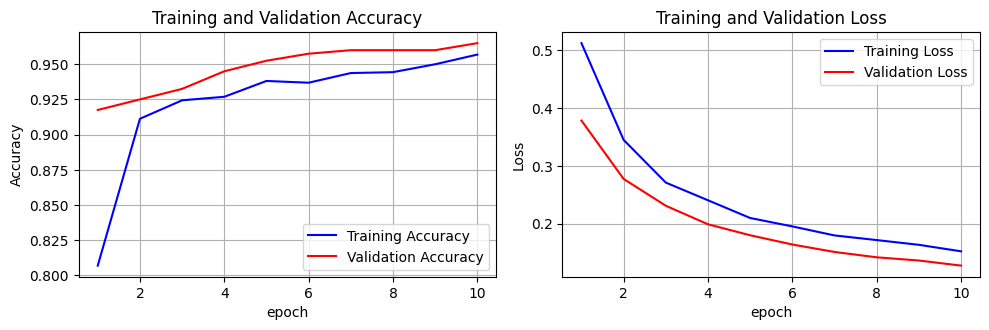

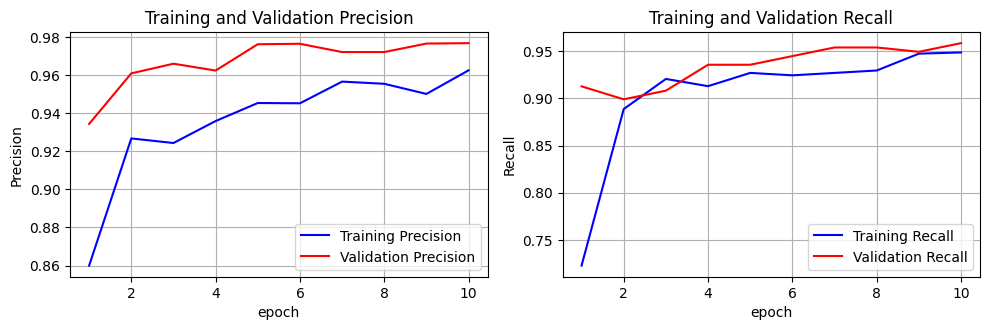

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
pre = history.history['precision']
val_pre = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color = 'red')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color = 'Blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color = 'red')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 3)
plt.plot(epochs_range, pre, label='Training Precision', color = 'blue')
plt.plot(epochs_range, val_pre, label='Validation Precision', color = 'red')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.title('Training and Validation Precision')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs_range, rec, label='Training Recall', color = 'Blue')
plt.plot(epochs_range, val_rec, label='Validation Recall', color = 'red')
plt.legend()
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.title('Training and Validation Recall')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
def F1(pre, rec):
    pre = np.array(pre)
    rec = np.array(rec)
    return (2 * (pre*rec)/(pre+rec))

f1 = F1(pre, rec)
val_f1 = F1(val_pre, val_rec)

print(f"Training F1: {f1}")
print(f"Validation F1: {val_f1}")


Training F1: [0.78526755 0.90731071 0.92248558 0.92427185 0.9360878  0.93471235
 0.94155842 0.94232017 0.9487836  0.95556984]
Validation F1: [0.92343388 0.92890994 0.9361702  0.94883722 0.9555035  0.96037299
 0.96296297 0.96296297 0.96279069 0.9675926 ]


In [ ]:
# Save to Google Drive
#model.save("/content/drive/MyDrive/CNN_for_UAV.keras")